# Optically-dark short GRBs

## Imports/loading/setup

In [42]:
%load_ext autoreload
%autoreload 2

In [74]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, importlib
from astropy.io import votable, ascii
from scipy import interpolate

from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait

from custom_utils import AsymmetricUncertainty, custom_iter

alpha = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
alpha += alpha.lower()
numeric = ".0123456789"
calc_code = importlib.import_module("Calculation Code.main")
graph_code = importlib.import_module("Graphing Code.Graphing_Beta_OX")

In [44]:
swift = pd.read_html("https://swift.gsfc.nasa.gov/archive/grb_table/fullview/")[0] # get latest Swift catalog
swift.columns = [col[0] for col in swift.columns] # reduce/flatten MultiIndex
sGRBs = swift[swift["BAT T90[sec]"].apply(pd.to_numeric, errors="coerce") <= 2].copy() # filter catalog for GRBs with a valid T90 that is <2s

## Data parsing and cleanup

In [45]:
# format columns
sGRBs.drop(['Time[UT]', 'BAT RA(J2000)', 'BAT Dec(J2000)', 'BAT 90%Error Radius[arcmin]',
            'BAT Fluence(15-150 keV)[10-7 erg/cm2]', 'BAT Fluence90% Error(15-150 keV)[10-7 erg/cm2]',
            'BAT 1-sec PeakPhoton Flux(15-150 keV)[ph/cm2/sec]', 'BAT 1-sec PeakPhoton Flux90% Error(15-150 keV)[ph/cm2/sec]',
            'BAT Photon Index(15-150 keV)(PL = simple power-law,CPL = cutoff power-law)', 'BAT Photon Index90% Error(15-150 keV)',
            'XRT RA(J2000)', 'XRT Dec(J2000)', 'XRT 90%Error Radius[arcsec]', 'XRT Column Density(NH)[1021 cm-2]',
            'XRT Early Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'XRT 11 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]',
            'XRT 24 Hour Flux(0.3-10 keV)[10-11 erg/cm2/s]', 'UVOT RA(J2000)', 'UVOT Dec(J2000)', 'UVOT 90%Error Radius[arcsec]',
            'Host Galaxy', 'Comments', 'References', 'Burst Advocate'],axis=1,inplace=True) # already in master catalog
sGRBs.rename(columns={'XRT Time to FirstObservation[sec]':'XRT dt [sec]',
                      'UVOT Time toFirst Observation[sec]':'UVOT dt [sec]',
                      'UVOT Other FilterMagnitudes':'Other UVOT Filters'},inplace=True)

mags = pd.Series([],dtype=float) # numerical magnitudes
lims = pd.Series([],dtype=object) # what kind of limit?
for idx,mag in sGRBs["UVOT Magnitude"].iteritems():
    #print(idx)
    try:
        mags[idx] = float(mag)
        lims[idx] = "equal"
    except ValueError:
        if ">" in mag:
            lims[idx] = "brightest"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        elif "=" in mag:
            lims[idx] = "equal"
            mags[idx] = float("".join([char for char in mag.split()[0] if char in "0123456789."]))
        else:
            print(mag)
            lims[idx] = "equal"
            mags[idx] = np.nan

sGRBs["UVOT Vmag"] = mags
sGRBs["UVOT Vmag lim"] = lims

See GCN 10184


In [46]:
def split_filters(string):
    UVOT_filters = ["B","U","UVW1","UVM2","UVW2","White"]
    name_idxs = custom_iter([string.index(i) for i in UVOT_filters if i in string])
    split_list = [string[name_idxs.current:next(name_idxs)] for i in range(len(UVOT_filters))]
    split_list = [item for item in split_list if len(item)>0]
    return np.unique(split_list).tolist()

In [47]:
optical_obs = []
for idx,entry in sGRBs["Other UVOT Filters"].iteritems():
    if pd.isna(entry):
        entries = []
    else:
        entries = split_filters(entry)
    try:
        filterdict = dict([entry.split(">") if ">" in entry else entry.split("=") if "=" in entry else None for entry in entries])
        filterdict["idx"] = idx
        optical_obs.append(filterdict)
    except:
        print("error",idx,end="; ")

for obs in optical_obs:
    sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()

error 221; error 349; error 528; error 569; error 617; error 646; error 728; error 861; error 1056; error 1071; error 1137; error 1290; 

<ipython-input-47-9935b0563a4e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sGRBs["Other UVOT Filters"][obs["idx"]] = obs.copy()


In [48]:
sGRBs["Redshift"] = ["".join([char for char in entry if char in numeric]) if type(entry) is str else entry for entry in sGRBs["Redshift"]]

In [49]:
sGRBs.to_csv("./Required Files/Files for Loading/Swift_sGRB_catalog.csv",index=False)
sGRBs.head()

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
27,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.9,brightest
35,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.7,brightest
61,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 61}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.2,brightest
70,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.5,brightest
108,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.9,brightest


## Legacy and new data imports

In [50]:
BetaXData = pd.read_csv("./Required Files/Legacy Data/BetaXData.csv", header=None)
BetaXData.columns = ["GRB","BetaX","Beta_X_pos","Beta_X_neg"]
BetaXData["GRB"] = [entry.split("-")[-1] for entry in BetaXData["GRB"]]

OpticalData = pd.read_csv("./Required Files/Legacy Data/OpticalData.csv", header=None)
OpticalData.columns = ["GRB","Time","Observatory","Instrument","Filter","Exposure","F_o","e_F_o"]
OpticalData["GRB"] = [entry.split("-")[-1] for entry in OpticalData["GRB"]]
# OpticalData["dt"] = OpticalData["dt"]*60*60

XRayData = pd.read_csv("./Required Files/Legacy Data/XRayData.csv", header=None)
XRayData.columns = ["GRB","Time","Exposure","F_x","e_F_x"]

filters = pd.read_csv("Required Files/Legacy Data/FilterInfo.csv", header=None)
filters.columns = ["Observatory","Instrument","Filter","Wavelength","Frequency"]

new_sGRBs = sGRBs[[int(grb[:6]) > 150301 for grb in sGRBs["GRB"]]].copy() # Fong et al. 2015 has data through March 2015, i.e. 150301A

In [51]:
new_sGRBs

,GRB,TriggerNumber,BAT T90[sec],XRT dt [sec],XRT InitialTemporalIndex,XRTSpectral Index(Gamma),UVOT dt [sec],UVOT Magnitude,Other UVOT Filters,Other Observatory Detections,Redshift,UVOT Vmag,UVOT Vmag lim
27,201006A,998907,0.49,83.94,-0.986,2.11701,88,V>18.9,"{'B': '19.8', 'U': '20.3', 'UVW1': '18.7', 'UV...","INTEGRAL, Fermi (GBM)",NaN,18.90,brightest
35,200907B,995004,0.83,80.13,-2.087,1.96454,84,V>17.7,"{'B': '19.4', 'U': '20.4', 'UVM2': '18.3', 'UV...",AstroSat CZTI,NaN,17.70,brightest
61,200522A,973628,0.62,83.42,-0.6754,1.38048,448,V>17.2,"{'White': '19.5', 'idx': 61}","VLA @ 6 GHZ (possibly from host), LCO (1m), Ge...",0.4,17.20,brightest
70,200411A,965784,0.22,50.74,-0.9587,1.76864,58,V>18.5,"{'B': '20.3', 'U': '21.0', 'UVM2': '18.1', 'UV...",Fermi (GBM),NaN,18.50,brightest
108,191031D,932608,0.29,88.83,-1.982,1.88342,93,V>19.9,"{'B': '20.4', 'U': '20.3', 'UVM2': '19.6', 'UV...","Fermi (GBM), AGILE (MCAL), Konus-Wind, AstroSa...",NaN,19.90,brightest
138,190627A,911609,1.60,109.76,-0.3297,1.95997,115,NaN,"{'White': '18.15', 'idx': 138}","NUTTelA-TAO, Montarrenti Observatory (0.53m), ...",1.942,NaN,equal
142,190610A,907754,0.62,292300,NaN,NaN,292282,V>20.3,{'idx': 142},"Insight-HXMT/HE, CALET, Konus-Wind",NaN,20.30,brightest
150,190427A,900730,0.3,3735.8,NaN,NaN,3737,NaN,"{'U': '19.9', 'idx': 150}","Fermi (GBM), CALET (CGBM)",NaN,NaN,equal
156,190326A,895006,0.08,NaN,NaN,NaN,NaN,NaN,"{'UVW1': '20.47', 'idx': 156}",Insight-HXMT/HE,NaN,NaN,equal
185,181123B,873186,0.26,80.25,-1.404,1.98751,84,V>19.8,"{'B': '20.1', 'U': '20.1', 'UVM2': '20.5', 'UV...",Insight-HXMT/HE,NaN,19.80,brightest


## Retrieve Swift XRT light curve and spectrum

In [99]:
def XRT_lightcurve(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    lightcurveURL = f"https://www.swift.ac.uk/xrt_curves/{int(trigger):0>8}/"
    
    fireFoxOptions = webdriver.FirefoxOptions()
    fireFoxOptions.headless = True
    with webdriver.Firefox() as browser:
        browser.get(lightcurveURL)
        browser.find_element_by_id('flux_makeDownload').click() # find the link to the data file and virtually click it
        WebDriverWait(browser, 30).until(lambda page: ".qdp" in page.current_url) # wait for the click to go through/data file to load
        lightcurveURL = browser.current_url # update the URL with the new page location (the actual data file)

    fluxdata = pd.read_table(lightcurveURL, header=1).apply(pd.to_numeric, errors="coerce").dropna().reset_index().apply(pd.to_numeric)
    fluxdata.columns = ["Time","Tpos","Tneg","Flux","Fluxpos","Fluxneg"]
    fluxdata["GRB"] = [burst_id]*len(fluxdata)
    print("Retrieved",burst_id)
    return fluxdata


def get_BetaX(burst_id):
    trigger = swift.loc[swift["GRB"] == burst_id, "TriggerNumber"]
    spectrumURL = f"https://www.swift.ac.uk/xrt_spectra/{int(trigger):0>8}/"
    
    spectra_tables = pd.read_html(spectrumURL)
    PC_table = spectra_tables[len(spectra_tables)-2]
    photon_index = PC_table.loc[PC_table[0]=="Photon index",1].values
    (Gamma, Gammapos, Gammaneg) = (float(num) for num in "".join([char for char in str(photon_index[0]) if char not in "[]()+-,"]).split())
    
    return Gamma, Gammapos, Gammaneg

In [100]:
burst = "160624A"
fluxdata = XRT_lightcurve(burst)
Gamma, Gammapos, Gammaneg = get_BetaX(burst)

Retrieved 160624A


Text(0, 0.5, 'Flux density')

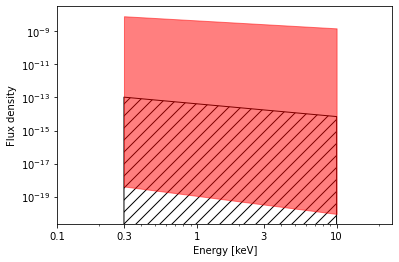

In [101]:
E_range = np.linspace(0.3,10,100)
spectrum = (E_range / 4.135667696e-18)**-(Gamma-1)
spec1 = (E_range / 4.135667696e-18)**-(Gamma+Gammapos-1)
spec2 = (E_range / 4.135667696e-18)**-(Gamma-Gammaneg-1)

plt.fill_between(E_range,[0]*len(E_range),spectrum,fc="none",ec="k",hatch="//")
plt.fill_between(E_range,spec1,spec2,alpha=0.5,color="r")
plt.xlim(1e-1,25)
#plt.ylim(1e-16,1e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.1,0.3,1,3,10])
plt.gca().set_xticklabels([0.1,0.3,1,3,10])
#plt.gca().set_yticks([])
#plt.gca().set_yticklabels([])
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density")

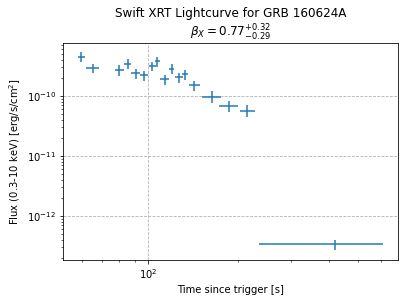

In [103]:
plt.errorbar(fluxdata.Time,fluxdata.Flux,xerr=np.array(fluxdata.Tneg,fluxdata.Tpos).T,yerr=np.array(fluxdata.Fluxneg,fluxdata.Fluxpos).T,linestyle="",capthick=0)
plt.xscale("log")
plt.yscale("log")
plt.title("Swift XRT Lightcurve for GRB %s\n$\\beta_X = %.2f_{-%.2f}^{+%.2f}$" % (burst,Gamma-1.,Gammaneg,Gammapos))
plt.xlabel("Time since trigger [s]")
plt.ylabel("Flux (0.3-10 keV) [erg/s/cm$^2$]")
plt.grid(linestyle="--")
plt.show()

In [104]:
xrt_data = pd.DataFrame(columns=['Time', 'Tpos', 'Tneg', 'Flux', 'Fluxpos', 'Fluxneg', 'GRB'])
for i in new_sGRBs.index:
    GRB_ID = new_sGRBs.loc[i,"GRB"]
    
    try:
        Gamma, Gammapos, Gammanegb = get_BetaX(GRB_ID)
        fluxdata = XRT_lightcurve(GRB_ID)
        xrt_data = xrt_data.append(fluxdata,ignore_index=True)
        
        new_sGRBs.loc[i,"Beta_X"] = Gamma - 1
        new_sGRBs.loc[i,"Beta_X_neg"] = Gammaneg
        new_sGRBs.loc[i,"Beta_X_pos"] = Gammapos
        #print(f"Found {GRB_ID} at index {i}: {Gamma, Gammapos, Gammaneg}")
        
    except:
        print("Failed to retrieve",GRB_ID)

Retrieved 201006A
Retrieved 200907B
Retrieved 200522A
Retrieved 200411A
Retrieved 191031D
Retrieved 190627A
Failed to retrieve 190610A
Failed to retrieve 190427A
Failed to retrieve 190326A
Retrieved 181123B
Retrieved 180805A
Retrieved 180727A
Failed to retrieve 180718A
Failed to retrieve 180715A
Retrieved 180402A
Retrieved 180204A
Retrieved 170728A
Retrieved 170524A
Retrieved 170428A
Failed to retrieve 170325A
Retrieved 170127B
Failed to retrieve 170112A
Retrieved 161104A
Retrieved 160927A
Retrieved 160821B
Failed to retrieve 160726A
Failed to retrieve 160714A
Retrieved 160624A
Retrieved 160601A
Retrieved 160525B
Retrieved 160411A
Retrieved 160408A
Retrieved 151229A
Failed to retrieve 151228A
Failed to retrieve 151205B
Retrieved 151127A
Retrieved 150831A
Retrieved 150728A
Failed to retrieve 150710A
Retrieved 150423A


## Converting x-ray flux values to spectral flux densities

$$ F_\text{x} = \int_{0.3\text{ keV}}^{10\text{ keV}} F(E)\ dE = \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} F_\nu\ d\nu = A \int_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} \nu^{-\beta}\ d\nu $$
$$ F_\text{x} = \left.\begin{cases} A\frac{\nu^{1-\beta}}{1-\beta}, & \beta \neq 1 \\ A\ln(\nu), & \beta = 1 \end{cases}\right\}_{7.254\cdot10^{16}\text{ Hz}}^{2.418\cdot10^{18}\text{ Hz}} $$

In [105]:
# grb_id = "160624A"
# i = 291
# beta = AsymmetricUncertainty(0.8,0.1,0.1)
# Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
# print("\n",Fx,"\n")
# if beta.value == 1:
#     integral = np.log(10) - np.log(0.3)
# else:
#     integral = (10**(1-beta) - 0.3**(1-beta))/(1-beta)
# A = Fx/integral
# log_mean_freq = 10**np.mean((np.log10(0.3), np.log10(10)))
# spectral_flux = A*log_mean_freq**(-beta)
# spectral_flux *= 1e23/241797944177033445 # convert flux per keV to flux per Hz
# spectral_flux*1e6


for i in xrt_data.index:
    grb_id = xrt_data.loc[i,"GRB"]
    beta = AsymmetricUncertainty(float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X"]),
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_pos"]/1.645), # convert 90% conf to 1-sigma
                                 float(new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,"Beta_X_neg"]/1.645)) # convert 90% conf to 1-sigma
    Fx = AsymmetricUncertainty(xrt_data.loc[i,"Flux"], xrt_data.loc[i,"Fluxpos"], np.abs(xrt_data.loc[i,"Fluxneg"]))
    if beta.value == 1:
        integral = np.log(10) - np.log(0.3)
    else:
        integral = (10**(1-beta) - 0.3**(1-beta))/(1-beta)
    A = Fx/integral
    log_mean_energy = 10**np.mean((np.log10(0.3),np.log10(10)))
    spectral_flux = A*log_mean_energy**(-beta) # erg/s/cm^2/keV
    spectral_flux *= 1e23*4.135684459202207e-18 # convert to Jy
    xrt_data.loc[i,"SpecFlux"] = spectral_flux

subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
raised 2.418e+18 ± 0.0 to -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = 0.014509564263661174 (+0.1082752815318033, -0.22401782385890337)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
divided 0.014509564263661174 (+0.1082752815318033, -0.22401782385890337) by -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = -0.1450956426366116 (+1.2051688442164925, -2.2547345608228664)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = -0.10000000000000009 (+0.1762917933130699, -0.364741641337386)
raised 7.254e+16 ± 0.0 to -0.10000000000000009 (+0.1762917933130699, -0.364741641337386) = 0.02060355896378431 (+0.1410140793346015, -0.29175326758883063)
subtracted 1.1 (+0.364741641337386, -0.1762917933130699) from 1.0 ± 0.0 = 

multiplied 4.548236168747099e-16 ± 4.716197350457733e-15 by 2.051866995852842e-13 ± 1.467751580224575e-12 = 9.33237568399635e-29 ± 1.1756242213828494e-27
multiplied 9.33237568399635e-29 ± 1.1756242213828494e-27 by 1e+23 ± 0.0 = 9.33237568399635e-06 (+0.00011756242213828492, -0.00012726706197333128)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
raised 2.418e+18 ± 0.0 to 0.28 (+0.1762917933130699, -0.1398176291793313) = 140400.2118258619 (+1047713.9207166069, -830945.523326964)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
divided 140400.2118258619 (+1047713.9207166069, -830945.523326964) by 0.28 (+0.1762917933130699, -0.1398176291793313) = 501429.3279495067 (+3750203.538434117, -2984408.1368929264)
subtracted 0.72 (+0.1398176291793313, -0.1762917933130699) from 1.0 ± 0.0 = 0.28 (+0.1762917933130699, -0.1398176291793313)
raised 7.254e

subtracted -4.505147227004029e-07 (+5.527270714278596e-06, -7.123734275372188e-05) from -1.1080452339964367e-07 (+1.3988041896402514e-06, -1.9103399817608352e-05) = 3.3971019930075927e-07 (+7.125107476924265e-05, -1.9886945621193835e-05)
divided 2.946524368e-11 ± 6.6502492e-12 by 3.3971019930075927e-07 (+7.125107476924265e-05, -1.9886945621193835e-05) = 8.673641162570224e-05 (+0.005077666565604372, -0.01819217127063744)
raised 4.188080220381607e+17 ± 0.0 to -1.4 (+0.1762917933130699, -4.072948328267477) = 2.1339243126559483e-25 ± 1.5264492232249138e-24
multiplied 8.673641162570224e-05 (+0.005077666565604372, -0.01819217127063744) by 2.1339243126559483e-25 ± 1.5264492232249138e-24 = 1.8508893756062005e-29 ± 1.0915946359041414e-27
multiplied 1.8508893756062005e-29 ± 1.0915946359041414e-27 by 1e+23 ± 0.0 = 1.8508893756062003e-06 (+0.00010915946359041413, -0.0004942382897221335)
subtracted 1.4 (+4.072948328267477, -0.1762917933130699) from 1.0 ± 0.0 = -0.3999999999999999 (+0.17629179331306

divided 2.125957504e-12 ± 5.55040288e-13 by 3.506557897319979 ± 0.0 = 6.062804511583408e-13 ± 1.582863606570451e-13
raised 4.188080220381607e+17 ± 0.0 to -1.0 (+0.1762917933130699, -0.08510638297872342) = 2.3877288575644395e-18 ± 1.708001937221749e-17
multiplied 6.062804511583408e-13 ± 1.582863606570451e-13 by 2.3877288575644395e-18 ± 1.708001937221749e-17 = 1.447633329007958e-30 ± 1.036217663258763e-29
multiplied 1.447633329007958e-30 ± 1.036217663258763e-29 by 1e+23 ± 0.0 = 1.447633329007958e-07 (+1.036217663258763e-06, -5.013368029013691e-07)
divided 1.226912192e-12 ± 3.2247673920000004e-13 by 3.506557897319979 ± 0.0 = 3.498907555291514e-13 ± 9.196389982508637e-14
raised 4.188080220381607e+17 ± 0.0 to -1.0 (+0.1762917933130699, -0.08510638297872342) = 2.3877288575644395e-18 ± 1.708001937221749e-17
multiplied 3.498907555291514e-13 ± 9.196389982508637e-14 by 2.3877288575644395e-18 ± 1.708001937221749e-17 = 8.354442539719792e-31 ± 5.980173689641836e-30
multiplied 8.354442539719792e-31 

subtracted 11778.378723941341 (+81875.17458886562, -111674.1675079614) from 23749.871469822196 (+179566.4320782481, -245349.35248016598) = 11971.492745880854 (+211459.74372893843, -258650.05118188928)
divided 1.05612572e-10 ± 2.11583172e-11 by 11971.492745880854 (+211459.74372893843, -258650.05118188928) = 8.822005262154055e-15 ± 1.9061200262613575e-13
raised 4.188080220381607e+17 ± 0.0 to -0.8 (+0.1762917933130699, -0.24316109422492402) = 7.987079488148969e-15 ± 5.713356939706195e-14
multiplied 8.822005262154055e-15 ± 1.9061200262613575e-13 by 7.987079488148969e-15 ± 5.713356939706195e-14 = 7.046205727369292e-29 ± 1.6036994139921614e-27
multiplied 7.046205727369292e-29 ± 1.6036994139921614e-27 by 1e+23 ± 0.0 = 7.046205727369292e-06 (+0.00016036994139921612, -0.0001425689590335804)
subtracted 0.8 (+0.24316109422492402, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.24316109422492402)
raised 2.418e+18 ± 0.0 to 0.19999999999999996 (+0.1762917933130699,

subtracted 1317503302987.5884 ± 9023137087090.463 from 15885307343052.557 ± 118607144363379.2 = 14567804040064.969 ± 118949870520853.88
divided 6.49189983e-11 ± 1.461288829e-11 by 14567804040064.969 ± 118949870520853.88 = 4.4563338524774995e-24 ± 3.640093689074644e-23
raised 4.188080220381607e+17 ± 0.0 to -0.29000000000000004 ± 0.1762917933130699 = 7.755604471975071e-06 ± 5.5477770939079866e-05
multiplied 4.4563338524774995e-24 ± 3.640093689074644e-23 by 7.755604471975071e-06 ± 5.5477770939079866e-05 = 3.456156275488839e-29 ± 3.752613407278184e-28
multiplied 3.456156275488839e-29 ± 3.752613407278184e-28 by 1e+23 ± 0.0 = 3.4561562754888387e-06 ± 3.7526134072781834e-05
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
raised 2.418e+18 ± 0.0 to 0.71 ± 0.1762917933130699 = 11278568213567.314 ± 84164494977846.28
subtracted 0.29000000000000004 ± 0.1762917933130699 from 1.0 ± 0.0 = 0.71 ± 0.1762917933130699
divided 11278568213567.314 ± 841644949778

subtracted 106.83069944235237 (+860.9671844512536, -821.243165119038) from 118.68133808655656 (+1019.5150987172178, -947.4654972381529) = 11.850638644204196 (+1309.141464001165, -1280.216919572093)
divided 1.3084424340000002e-10 ± 2.87181102e-11 by 11.850638644204196 (+1309.141464001165, -1280.216919572093) = 1.1041113253756341e-11 ± 1.1927668707150775e-09
raised 4.188080220381607e+17 ± 0.0 to -0.97 (+0.1762917933130699, -0.1276595744680851) = 8.065763022428256e-18 ± 5.769641232016319e-17
multiplied 1.1041113253756341e-11 ± 1.1927668707150775e-09 by 8.065763022428256e-18 ± 5.769641232016319e-17 = 8.905500300859042e-29 ± 9.641642617182725e-27
multiplied 8.905500300859042e-29 ± 9.641642617182725e-27 by 1e+23 ± 0.0 = 8.905500300859042e-06 (+0.0009641642617182726, -0.0009848745414480398)
subtracted 0.97 (+0.1276595744680851, -0.1762917933130699) from 1.0 ± 0.0 = 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851)
raised 2.418e+18 ± 0.0 to 0.030000000000000027 (+0.17629179331306

divided 3.204920983270574 (+21.93499591941551, -15.88396256233537) by 0.030000000000000027 (+0.1762917933130699, -0.1276595744680851) = 106.83069944235237 (+860.9671844512536, -821.243165119038)
subtracted 106.83069944235237 (+860.9671844512536, -821.243165119038) from 118.68133808655656 (+1019.5150987172178, -947.4654972381529) = 11.850638644204196 (+1309.141464001165, -1280.216919572093)
divided 9.496670559999999e-13 ± 1.8313081019999998e-13 by 11.850638644204196 (+1309.141464001165, -1280.216919572093) = 8.013636096012889e-14 ± 8.657093655636531e-12
raised 4.188080220381607e+17 ± 0.0 to -0.97 (+0.1762917933130699, -0.1276595744680851) = 8.065763022428256e-18 ± 5.769641232016319e-17
multiplied 8.013636096012889e-14 ± 8.657093655636531e-12 by 8.065763022428256e-18 ± 5.769641232016319e-17 = 6.463608969841709e-31 ± 6.99789752314311e-29
multiplied 6.463608969841709e-31 ± 6.99789752314311e-29 by 1e+23 ± 0.0 = 6.463608969841709e-08 (+6.99789752314311e-06, -7.148212729166085e-06)
subtracted

raised 7.254e+16 ± 0.0 to -0.1299999999999999 (+0.1762917933130699, -0.1945288753799392) = 0.006428726034536697 (+0.04399923744475596, -0.048550882697661744)
subtracted 1.13 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = -0.1299999999999999 (+0.1762917933130699, -0.1945288753799392)
divided 0.006428726034536697 (+0.04399923744475596, -0.048550882697661744) by -0.1299999999999999 (+0.1762917933130699, -0.1945288753799392) = -0.0494517387272054 (+0.3464505802437688, -0.3794413998958334)
subtracted -0.0494517387272054 (+0.3464505802437688, -0.3794413998958334) from -0.03134781890083789 (+0.23858478466261301, -0.2616045551720365) = 0.018103919826367512 (+0.44821699591538827, -0.4341254977975875)
divided 2.097510264e-12 ± 5.48476948e-13 by 0.018103919826367512 (+0.44821699591538827, -0.4341254977975875) = 1.1585945387059627e-10 ± 2.778433287011306e-09
raised 4.188080220381607e+17 ± 0.0 to -1.13 (+0.1762917933130699, -0.1945288753799392) = 1.2221459116960016e-20 ± 8.742314179147

divided 2717751.247620535 (+20280780.051162727, -20980117.294306267) by 0.3500000000000001 (+0.1762917933130699, -0.182370820668693) = 7765003.564630099 (+58086171.54069856, -60070654.075140916)
subtracted 0.6499999999999999 (+0.182370820668693, -0.1762917933130699) from 1.0 ± 0.0 = 0.3500000000000001 (+0.1762917933130699, -0.182370820668693)
raised 7.254e+16 ± 0.0 to 0.3500000000000001 (+0.1762917933130699, -0.182370820668693) = 796530.0100852968 (+5451579.808711286, -5639565.319356502)
subtracted 0.6499999999999999 (+0.182370820668693, -0.1762917933130699) from 1.0 ± 0.0 = 0.3500000000000001 (+0.1762917933130699, -0.182370820668693)
divided 796530.0100852968 (+5451579.808711286, -5639565.319356502) by 0.3500000000000001 (+0.1762917933130699, -0.182370820668693) = 2275800.028815133 (+15621016.772421768, -16153766.81607303)
subtracted 2275800.028815133 (+15621016.772421768, -16153766.81607303) from 7765003.564630099 (+58086171.54069856, -60070654.075140916) = 5489203.535814965 (+602905

subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 7.254e+16 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.00042450664197413683 (+0.002905391898294221, -0.002805

subtracted -0.0021225332098706823 (+0.01463884126711083, -0.014150260679399895) from -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763) = 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438)
divided 1.155648084e-09 ± 1.7580703740000001e-10 by 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438) = 1.0801499912184121e-06 (+1.6672029042645624e-05, -1.636529683148832e-05)
raised 4.188080220381607e+17 ± 0.0 to -1.2000000000000002 (+0.1762917933130699, -0.17021276595744683) = 7.138089843359271e-22 ± 5.106053495938659e-21
multiplied 1.0801499912184121e-06 (+1.6672029042645624e-05, -1.636529683148832e-05) by 7.138089843359271e-22 ± 5.106053495938659e-21 = 7.710207681620753e-28 ± 1.311655079071799e-26
multiplied 7.710207681620753e-28 ± 1.311655079071799e-26 by 1e+23 ± 0.0 = 7.710207681620752e-05 (+0.001311655079071799, -0.0012838182518467203)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.200000000

subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0.0010526372756065661 (+0.007906056282002428, -0.007640815040055763)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 7.254e+16 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.00042450664197413683 (+0.002905391898294221, -0.002805205970766834) by -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = -0

divided 5.68045107e-10 ± 8.4679266e-11 by 0.0010698959342641161 (+0.016209120988787788, -0.016512956371286438) = 5.309349150772373e-07 (+8.19492226943413e-06, -8.044151392615744e-06)
raised 4.188080220381607e+17 ± 0.0 to -1.2000000000000002 (+0.1762917933130699, -0.17021276595744683) = 7.138089843359271e-22 ± 5.106053495938659e-21
multiplied 5.309349150772373e-07 (+8.19492226943413e-06, -8.044151392615744e-06) by 7.138089843359271e-22 ± 5.106053495938659e-21 = 3.7898611247976446e-28 ± 6.447274691409227e-27
multiplied 3.7898611247976446e-28 ± 6.447274691409227e-27 by 1e+23 ± 0.0 = 3.7898611247976444e-05 (+0.0006447274691409226, -0.0006310445846788762)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 1.20000000

raised 4.188080220381607e+17 ± 0.0 to -1.2000000000000002 (+0.1762917933130699, -0.17021276595744683) = 7.138089843359271e-22 ± 5.106053495938659e-21
multiplied 2.365055207673451e-07 (+3.650538011342529e-06, -3.58337886114069e-06) by 7.138089843359271e-22 ± 5.106053495938659e-21 = 1.6881976556877812e-28 ± 2.8720108865726594e-27
multiplied 1.6881976556877812e-28 ± 2.8720108865726594e-27 by 1e+23 ± 0.0 = 1.688197655687781e-05 (+0.0002872010886572659, -0.0002811061753759174)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
raised 2.418e+18 ± 0.0 to -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683) = 0.0002105274551213134 (+0.0015710271555517056, -0.0015168538053602677)
subtracted 1.2000000000000002 (+0.17021276595744683, -0.1762917933130699) from 1.0 ± 0.0 = -0.20000000000000018 (+0.1762917933130699, -0.17021276595744683)
divided 0.0002105274551213134 (+0.0015710271555

raised 4.188080220381607e+17 ± 0.0 to -0.77 (+0.1762917933130699, -0.1945288753799392) = 2.6980404491328868e-14 ± 1.9299755494525376e-13
multiplied 7.208433278101827e-15 ± 1.1491118186789149e-13 by 2.6980404491328868e-14 ± 1.9299755494525376e-13 = 1.94486445591943e-28 ± 3.398181339763085e-27
multiplied 1.94486445591943e-28 ± 3.398181339763085e-27 by 1e+23 ± 0.0 = 1.94486445591943e-05 (+0.00033981813397630854, -0.00032766668003322234)
subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392)
raised 2.418e+18 ± 0.0 to 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392) = 16911.999152533404 (+126203.06414660877, -139258.55354108554)
subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392)
divided 16911.999152533404 (+126203.06414660877, -139258.55354108554) by 0.22999999999999998 (+0.1762917933130699, -0.1945288753799

subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392)
raised 2.418e+18 ± 0.0 to 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392) = 16911.999152533404 (+126203.06414660877, -139258.55354108554)
subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392)
divided 16911.999152533404 (+126203.06414660877, -139258.55354108554) by 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392) = 73530.43109797133 (+552222.0428785848, -608089.4375369888)
subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392)
raised 7.254e+16 ± 0.0 to 0.22999999999999998 (+0.1762917933130699, -0.1945288753799392) = 7549.754624253457 (+51671.737849396755, -57017.09004071366)
subtracted 0.77 (+0.1945288753799392, -0.1762917933130699) from 1.0 ± 0.0 = 0.2299

subtracted 0.95 (+0.16413373860182373, -0.1762917933130699) from 1.0 ± 0.0 = 0.050000000000000044 (+0.1762917933130699, -0.16413373860182373)
divided 6.966728364684676 (+47.68141213113126, -44.39303888070842) by 0.050000000000000044 (+0.1762917933130699, -0.16413373860182373) = 139.3345672936934 (+1057.6447892752713, -1014.713641316829)
subtracted 139.3345672936934 (+1057.6447892752713, -1014.713641316829) from 166.03620962791962 (+1353.60200000176, -1293.612588050295) = 26.70164233422622 (+1691.7098298122, -1670.9416591381387)
divided 1.1937662209999998e-12 ± 2.780408727e-13 by 26.70164233422622 (+1691.7098298122, -1670.9416591381387) = 4.470759536277017e-14 ± 2.7977418039099167e-12
raised 4.188080220381607e+17 ± 0.0 to -0.95 (+0.1762917933130699, -0.16413373860182373) = 1.815874198422953e-17 ± 1.2989400529426284e-16
multiplied 4.470759536277017e-14 ± 2.7977418039099167e-12 by 1.815874198422953e-17 ± 1.2989400529426284e-16 = 8.1183368892788e-31 ± 5.11343021732592e-29
multiplied 8.1183

divided 1.8859440569999999e-10 ± 3.443263197e-11 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 1.8159674754316664e-10 ± 1.7574817965698248e-08
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 1.8159674754316664e-10 ± 1.7574817965698248e-08 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 1.2836086184461217e-28 ± 1.2456569854111754e-26
multiplied 1.2836086184461217e-28 ± 1.2456569854111754e-26 by 1e+23 ± 0.0 = 1.2836086184461215e-05 (+0.0012456569854111753, -0.0012674434775588749)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.17629179331

divided 1.151447889e-10 ± 2.410492814e-11 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 1.108724253149176e-10 ± 1.0730168959604565e-08
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 1.108724253149176e-10 ± 1.0730168959604565e-08 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 7.836968591544991e-29 ± 7.605262202195572e-27
multiplied 7.836968591544991e-29 ± 7.605262202195572e-27 by 1e+23 ± 0.0 = 7.83696859154499e-06 (+0.0007605262202195571, -0.000773827779488756)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 

raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 9.109362547757058e-11 ± 8.81598830301022e-09 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 6.438912829136336e-29 ± 6.2485411798968765e-27
multiplied 6.438912829136336e-29 ± 6.2485411798968765e-27 by 1e+23 ± 0.0 = 6.438912829136335e-06 (+0.0006248541179896876, -0.0006357827798289974)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.28086415160758454 (+2.095903401018387, -1.0118154349743937) by -0.0299

subtracted -10.400672436959015 (+77.05657939596153, -70.11698489103604) from -9.362138386919545 (+74.74152367759051, -64.53091971811713) = 1.0385340500394697 (+102.48261770591928, -100.50848734247373)
divided 1.224527897e-11 ± 2.773794969e-12 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 1.1790926806429327e-11 ± 1.1411195076140794e-09
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 1.1790926806429327e-11 ± 1.1411195076140794e-09 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 8.334364724567781e-30 ± 8.087955626116477e-28
multiplied 8.334364724567781e-30 ± 8.087955626116477e-28 by 1e+23 ± 0.0 = 8.33436472456778e-07 (+8.087955626116476e-05, -8.229413387182699e-05)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999

raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 4.920115454862365e-12 ± 4.761661002186736e-10 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 3.477761957223413e-30 ± 3.374940366777949e-28
multiplied 3.477761957223413e-30 ± 3.374940366777949e-28 by 1e+23 ± 0.0 = 3.4777619572234125e-07 (+3.374940366777949e-05, -3.433967832451214e-05)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
raised 2.418e+18 ± 0.0 to -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = 0.28086415160758454 (+2.095903401018387, -1.0118154349743937)
subtracted 1.0299999999999998 (+0.08510638297872342, -0.1762917933130699) from 1.0 ± 0.0 = -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342)
divided 0.28086415160758454 (+2.095903401018387, -1.0118154349743937) by -0.0299

divided 0.3120201731087684 (+2.1355163698706208, -1.0309389371789204) by -0.029999999999999805 (+0.1762917933130699, -0.08510638297872342) = -10.400672436959015 (+77.05657939596153, -70.11698489103604)
subtracted -10.400672436959015 (+77.05657939596153, -70.11698489103604) from -9.362138386919545 (+74.74152367759051, -64.53091971811713) = 1.0385340500394697 (+102.48261770591928, -100.50848734247373)
divided 2.748670577e-12 ± 5.872493220000001e-13 by 1.0385340500394697 (+102.48261770591928, -100.50848734247373) = 2.6466831558344534e-12 ± 2.5614448429381686e-10
raised 4.188080220381607e+17 ± 0.0 to -1.0299999999999998 (+0.1762917933130699, -0.08510638297872342) = 7.068455992809013e-19 ± 5.056242667854365e-18
multiplied 2.6466831558344534e-12 ± 2.5614448429381686e-10 by 7.068455992809013e-19 ± 5.056242667854365e-18 = 1.8707963413924714e-30 ± 1.8154848921817432e-28
multiplied 1.8707963413924714e-30 ± 1.8154848921817432e-28 by 1e+23 ± 0.0 = 1.8707963413924714e-07 (+1.815484892181743e-05, -1

subtracted 1.4 (+0.48632218844984804, -0.1762917933130699) from 1.0 ± 0.0 = -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804)
raised 2.418e+18 ± 0.0 to -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804) = 4.4321809359857454e-08 (+3.3074434898478253e-07, -9.123982040959519e-07)
subtracted 1.4 (+0.48632218844984804, -0.1762917933130699) from 1.0 ± 0.0 = -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804)
divided 4.4321809359857454e-08 (+3.3074434898478253e-07, -9.123982040959519e-07) by -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804) = -1.1080452339964367e-07 (+8.377633938055886e-07, -2.281518213254598e-06)
subtracted 1.4 (+0.48632218844984804, -0.1762917933130699) from 1.0 ± 0.0 = -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804)
raised 7.254e+16 ± 0.0 to -0.3999999999999999 (+0.1762917933130699, -0.48632218844984804) = 1.8020588908016112e-07 (+1.233358158363764e-06, -3.40236733341728e-06)
subtracted 1.4 (+0.4863221884

subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
raised 7.254e+16 ± 0.0 to 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 2355.675744788268 (+16122.624588599534, -27797.628601033677)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
divided 2355.675744788268 (+16122.624588599534, -27797.628601033677) by 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 11778.378723941341 (+82576.60270671594, -139375.36759113954)
subtracted 11778.378723941341 (+82576.60270671594, -139375.36759113954) from 23749.871469822196 (+180867.6421011568, -306284.52105898305) = 11971.492745880854 (+228338.77693111481, -317220.90592348017)
divided 5.069276347e-10 ± 9.396735770000001e-11 by 11971.492745880854 (+228338.77693111481, -317220.90592348017) = 4.234456349434146e-14 ± 1.1220747276167396e-12
raised 4.1880802

divided 3.392920137e-10 ± 6.400071289999999e-11 by 11971.492745880854 (+228338.77693111481, -317220.90592348017) = 2.8341663057578468e-14 ± 7.510171052034259e-13
raised 4.188080220381607e+17 ± 0.0 to -0.8 (+0.1762917933130699, -0.303951367781155) = 7.987079488148969e-15 ± 5.713356939706195e-14
multiplied 2.8341663057578468e-14 ± 7.510171052034259e-13 by 7.987079488148969e-15 ± 5.713356939706195e-14 = 2.2636711566721437e-28 ± 6.213147866026792e-27
multiplied 2.2636711566721437e-28 ± 6.213147866026792e-27 by 1e+23 ± 0.0 = 2.2636711566721433e-05 (+0.0006213147866026791, -0.0005141789083955525)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0.303951367781155)
raised 2.418e+18 ± 0.0 to 0.19999999999999996 (+0.1762917933130699, -0.303951367781155) = 4749.974293964438 (+35445.916541814506, -61113.649210025)
subtracted 0.8 (+0.303951367781155, -0.1762917933130699) from 1.0 ± 0.0 = 0.19999999999999996 (+0.1762917933130699, -0

subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
raised 2.418e+18 ± 0.0 to 0.49 (+0.1762917933130699, -0.2188449848024316) = 1018341834.2932793 (+7599211582.105483, -9433504032.95853)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
divided 1018341834.2932793 (+7599211582.105483, -9433504032.95853) by 0.49 (+0.1762917933130699, -0.2188449848024316) = 2078248641.4148557 (+15536346484.925604, -19266563357.302128)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
raised 7.254e+16 ± 0.0 to 0.49 (+0.1762917933130699, -0.2188449848024316) = 182676633.7526757 (+1250268333.2455857, -1552057241.270382)
subtracted 0.51 (+0.2188449848024316, -0.1762917933130699) from 1.0 ± 0.0 = 0.49 (+0.1762917933130699, -0.2188449848024316)
divided 182676633.7526757 (+1250268333.2455857, -15

## Load new optical data

In [106]:
new_optical = pd.read_excel("./Required Files/Files for Loading/newData.xlsx")

for col in ["GRB","TriggerNumber","Observatory","Instrument","Source","E(B-V)"]:
    for i in new_optical.index:
        if pd.isna(new_optical.loc[i,col]):
            new_optical.loc[i,col] = new_optical.loc[i-1,col] # deal with merged Excel cells
new_optical.drop(new_optical[new_optical["Magnitude"]=="spectroscopy only"].index,axis=0,inplace=True)
new_optical["mag_w_err"] = [AsymmetricUncertainty(mag,err,err) if isinstance(err,(float,int)) else AsymmetricUncertainty(mag,np.inf,0) for mag,err in new_optical[["Magnitude","Mag error"]].values]

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


## Correcting for extinction

$ A_b = R_b \cdot E_{B-V} $ for an arbitrary band $b$

In [107]:
RbTable = pd.read_csv("./Required Files/Rb.csv") # Table 6 from Schlafly & Finkbeiner (2011)
Rb = interpolate.interp1d(RbTable["lambda_eff"],RbTable["R_b"]) # function that takes a wavelength [Ang] and returns the corresponding R_b value

In [108]:
for i in new_optical.index:    
    try:
        new_optical.loc[i,"Extinction"] = Rb(new_optical.loc[i,"λ_eff"])*new_optical.loc[i,"E(B-V)"]
    except ValueError:
        pass

## Converting optical magnitudes to spectral flux densities

In [109]:
new_optical["Flux (Jy)"] = 3631*10**(-(new_optical["mag_w_err"]-new_optical["Extinction"])/2.5) # AB mag = 0 at F_nu = 3631 Jy

subtracted 5.059996988884631 ± 0.0 from 21.1 (+inf, -0.0) = 16.04000301111537 (+inf, -0.0)
subtracted 5.4553991015625005 ± 0.0 from 20.2 (+inf, -0.0) = 14.744600898437499 (+inf, -0.0)
subtracted 5.059996988884631 ± 0.0 from 21.0 (+inf, -0.0) = 15.940003011115369 (+inf, -0.0)
subtracted 3.4931371026490066 ± 0.0 from 18.9 (+inf, -0.0) = 15.406862897350992 (+inf, -0.0)
subtracted 4.5873035 ± 0.0 from 19.8 (+inf, -0.0) = 15.2126965 (+inf, -0.0)
subtracted 5.4553991015625005 ± 0.0 from 20.3 (+inf, -0.0) = 14.8446008984375 (+inf, -0.0)
subtracted 7.287927688378767 ± 0.0 from 18.7 (+inf, -0.0) = 11.412072311621232 (+inf, -0.0)
subtracted nan ± 0.0 from 17.3 (+inf, -0.0) = nan (+inf, -0.0)
subtracted 2.4303922545036416 ± 0.0 from 20.4 (+inf, -0.0) = 17.969607745496358 (+inf, -0.0)
subtracted 2.6203098046875 ± 0.0 from 19.7 (+inf, -0.0) = 17.079690195312498 (+inf, -0.0)
subtracted 2.4303922545036416 ± 0.0 from 21.0 (+inf, -0.0) = 18.56960774549636 (+inf, -0.0)
subtracted 1.6778060099337746 ± 0.

subtracted 0.09913598910081743 ± 0.0 from 21.1 ± 0.1 = 21.000864010899186 ± 0.1
subtracted 0.07568879432624112 ± 0.0 from 21.1 ± 0.1 = 21.02431120567376 ± 0.1
subtracted 0.04426990478641276 ± 0.0 from 20.7 ± 0.2 = 20.65573009521359 ± 0.2
subtracted 0.02767377640778889 ± 0.0 from 20.9 ± 0.4 = 20.87232622359221 ± 0.4
subtracted 0.01869691401879721 ± 0.0 from 20.0 (+inf, -0.0) = 19.981303085981203 (+inf, -0.0)
subtracted nan ± 0.0 from 22.3 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 22.1 ± 0.4 = nan ± 0.4
subtracted nan ± 0.0 from 20.9 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 20.6 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 20.1 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 19.9 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 19.2 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 22.2 ± 0.2 = nan ± 0.2
subtracted nan ± 0.0 from nan (+nan, -nan) = nan (+nan, -nan)
subtracted 0.09888031062670298 ± 0.0 from 22.1 ± 0.

subtracted nan ± 0.0 from 19.9 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 20.0 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 18.7 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 18.7 (+inf, -0.0) = nan (+inf, -0.0)
subtracted nan ± 0.0 from 18.2 (+inf, -0.0) = nan (+inf, -0.0)
subtracted 0.09882268348623853 ± 0.0 from 19.5 (+inf, -0.0) = 19.40117731651376 (+inf, -0.0)
subtracted 0.06423266233766234 ± 0.0 from 19.4 (+inf, -0.0) = 19.335767337662336 (+inf, -0.0)
subtracted 0.047141388888888885 ± 0.0 from 18.6 (+inf, -0.0) = 18.552858611111112 (+inf, -0.0)
subtracted nan ± 0.0 from 17.0 (+inf, -0.0) = nan (+inf, -0.0)
subtracted 0.09882268348623853 ± 0.0 from 20.0 (+inf, -0.0) = 19.90117731651376 (+inf, -0.0)
subtracted 0.06423266233766234 ± 0.0 from 20.0 (+inf, -0.0) = 19.935767337662337 (+inf, -0.0)
subtracted 0.047141388888888885 ± 0.0 from 19.3 (+inf, -0.0) = 19.25285861111111 (+inf, -0.0)
subtracted nan ± 0.0 from 17.0 (+inf, -0.0) = nan (+inf, -0

divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5

divided nan (+nan, -nan) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+nan, -nan) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5

divided -20.70117731651376 (+0.0, -inf) by 2.5 ± 0.0 = -8.280470926605505 (+0.0, -inf)
divided -20.735767337662338 (+0.0, -inf) by 2.5 ± 0.0 = -8.294306935064935 (+0.0, -inf)
divided -19.85285861111111 (+0.0, -inf) by 2.5 ± 0.0 = -7.941143444444444 (+0.0, -inf)
divided -25.202008097165994 (+0.0, -inf) by 2.5 ± 0.0 = -10.080803238866398 (+0.0, -inf)
divided nan ± 0.3 by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
divided -19.30117731651376 (+0.0, -inf) by 2.5 ± 0.0 = -7.720470926605503 (+0.0, -inf)
divided -19.235767337662338 (+0.0, -inf) by 2.5 ± 0.0 = -7.694306935064935 (+0.0, -inf)
divided -18.35285861111111 (+0.0, -inf) by 2.5 ± 0.0 = -7.341143444444444 (+0.0, -inf)
divided nan (+0.0, -inf) by 2.5 ± 0.0 = nan (+nan, -nan)
raised 10.0 ± 0.0 to -6.4160012044461485 (+0.0, -inf) = 3.837061813431993e-07 (+0.0, -inf)
raised 10.0 ± 0.0 

raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to -8.800447875749319 ± 0.04 = 1.583259578945608e-09 ± 1.4582359619280745e-10
raised 10.0 ± 0.0 to -8.734378226980727 ± 0.039999999999999994 = 1.8434092950940035e-09 ± 1.6978427052680456e-10
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to -8.448126003219624 (+0.0, -inf) = 3.5634773014245127e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.92563528125 (+0.0, -inf) = 1.186764970220749e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.368126003219626 (+0.0, -inf) = 4.284242023069109e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.7379959867549655 (+0.0, -inf) = 1.8281171093

raised 10.0 ± 0.0 to -8.210994046875 (+0.0, -inf) = 6.15185305351943e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.26750486748924 (+0.0, -inf) = 5.401260611014332e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to -9.806918156682027 (+0.0, -inf) = 1.5598464300682986e-10 (+0.0, -inf)
raised 10.0 ± 0.0 to -9.697330624514697 (+0.0, -inf) = 2.007563890225096e-10 (+0.0, -inf)
raised 10.0 ± 0.0 to -9.447300274659401 (+0.0, -inf) = 3.570259022462511e-10 (+0.0, -inf)
raised 10.0 ± 0.0 to -9.464494884160757 (+0.0, -inf) = 3.4316668215784416e-10 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.52753540315663 (+0.0, -inf) = 2.9680047854700878e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -8.339705897300954 (+0.0, -inf) = 4.573978329656537e-09 (+0.0, -inf)
raised 10.0 ± 0.0 to -7.42628892971955 (+0.0, -inf) = 3.747236211962243e-08 (+0.0, -inf)
raised 10.0 ± 0.0 to nan (+nan, -nan) = nan (+nan, -nan)
raised 10.0 ± 0.0 to na

multiplied 3631.0 ± 0.0 by 1.0948887260332967e-08 (+0.0, -inf) = 3.9755409642269e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.6286343626210662e-08 (+0.0, -inf) = 5.913571370677091e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 6.908280830792719e-09 (+0.0, -inf) = 2.508396769660836e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 3.236086086581527e-08 (+0.0, -inf) = 0.00011750228580377525 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 7.319509857414078e-09 (+0.0, -inf) = 2.6577140292270517e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 5.392915229797969e-09 (+0.0, -inf) = 1.9581675199396425e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 6.753688558070493e-09 (+0.0, -inf) = 2.452264315435396e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by 1.354451872648744e-07 (+nan, -nan) = 0.0004918014749587589 (+nan, -nan)
multiplied 3631.0 ± 0.0 by 1.3354989465507743e-07 (+nan, -nan) = 0.000484919667

multiplied 3631.0 ± 0.0 by 3.7426253751427927e-08 (+0.0, -inf) = 0.0001358947273714348 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 5.3525946414844625e-08 (+0.0, -inf) = 0.00019435271143230083 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 9.253062987697416e-08 (+0.0, -inf) = 0.00033597871708329315 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan, -nan) = nan (+nan, -nan)
multiplied 3631.0 ± 0.0 by 6.7900660172180766e-09 (+0.0, -inf) = 2.4654729708518838e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 4.284242023069109e-09 (+0.0, -inf) = 1.5556082785763936e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.828117109399091e-08 (+0.0, -inf) = 6.637893224228099e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.1719157742534542e-08 (+0.0, -inf) = 4.255226176314292e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 1.0823425166092165e-08 (+0.0, -inf) = 3.929985677808065e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by 9.245027469638235e-09 (+0.0, -inf) = 3.356869474225643e-05 (+0.0, -inf)
multiplied 3631.0 ± 0.0 by nan (+nan,

## Putting it all together

In [110]:
display(new_optical[~new_optical["Flux (Jy)"].isna()])
display(xrt_data)

,GRB,TriggerNumber,Observatory,Instrument,Filter,λ_eff,Time (s),Magnitude,Mag error,Source,E(B-V),Extinction,mag_w_err,Flux (Jy)
0,201006A,998907,Swift,UVOT,white_FC,3885.68,163.0,21.1,3-sigma,GCN 28565,1.27,5.059997,"21.1 (+inf, -0.0)","0.0013932371444571566 (+0.0, -inf)"
1,201006A,998907,Swift,UVOT,u_FC,3520.95,424.5,20.2,3-sigma,GCN 28565,1.27,5.455399,"20.2 (+inf, -0.0)","0.004593946038154898 (+0.0, -inf)"
2,201006A,998907,Swift,UVOT,white,3885.68,813.5,21,3-sigma,GCN 28565,1.27,5.059997,"21.0 (+inf, -0.0)","0.0015276541509540685 (+0.0, -inf)"
3,201006A,998907,Swift,UVOT,v,5411.43,1026.0,18.9,3-sigma,GCN 28565,1.27,3.493137,"18.9 (+inf, -0.0)","0.0024962098350395814 (+0.0, -inf)"
4,201006A,998907,Swift,UVOT,b,4346.25,1038.0,19.8,3-sigma,GCN 28565,1.27,4.587303,"19.8 (+inf, -0.0)","0.0029850227741289445 (+0.0, -inf)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,150423A,638808,Johnson,RATIR,z,NaN,91278.0,22.07,3-sigma,GCN 17754,0.03,NaN,"22.07 (+inf, -0.0)","nan (+nan, -nan)"
597,150423A,638808,Akeno,MITSuME,g',4727.80,23744.0,19.4,UL,GCN 17763,0.03,0.098823,"19.4 (+inf, -0.0)","6.91122962026598e-05 (+0.0, -inf)"
598,150423A,638808,Akeno,MITSuME,Rc,6479.38,23744.0,19.3,UL,GCN 17763,0.03,0.064233,"19.3 (+inf, -0.0)","7.340393024633758e-05 (+0.0, -inf)"
599,150423A,638808,Akeno,MITSuME,Ic,7845.53,23744.0,18.4,UL,GCN 17763,0.03,0.047141,"18.4 (+inf, -0.0)","0.00016553232097824908 (+0.0, -inf)"


,Time,Tpos,Tneg,Flux,Fluxpos,Fluxneg,GRB,SpecFlux
0,153.568,60.668,-62.190,9.464503e-12,2.120667e-12,-2.120667e-12,201006A,6.411789379624487e-07 (+2.9436268289176252e-05...
1,283.514,106.234,-69.278,4.974444e-12,1.289085e-12,-1.289085e-12,201006A,3.3699698866644917e-07 (+1.547145900993068e-05...
2,453.501,116.774,-63.753,4.827674e-12,1.253339e-12,-1.253339e-12,201006A,3.2705394757677753e-07 (+1.5014977015332531e-0...
3,688.759,99.652,-118.485,4.014022e-12,1.043056e-12,-1.043056e-12,201006A,2.7193256377670545e-07 (+1.2484366400756057e-0...
4,890.072,161.607,-101.661,3.263878e-12,8.528112e-13,-8.528112e-13,201006A,2.2111355671629525e-07 (+1.0151278351854859e-0...
...,...,...,...,...,...,...,...,...
436,740.288,98.123,-94.940,5.081034e-12,1.133393e-12,-1.133393e-12,150423A,3.0682322643150886e-07 (+4.128930612623815e-06...
437,983.210,191.177,-144.798,3.186325e-12,6.861677e-13,-6.861677e-13,150423A,1.9240937663101223e-07 (+2.5892353543288845e-0...
438,4742.155,480.662,-311.650,9.741812e-13,2.616720e-13,-2.616720e-13,150423A,"5.882688336501138e-08 (+7.916843162637609e-07,..."
439,5872.965,1047.289,-650.147,4.456341e-13,1.225401e-13,-1.225401e-13,150423A,"2.69100501625829e-08 (+3.621553134555228e-07, ..."


In [127]:
max_dt = 0.1
nu_x = 10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18 # xray frequency [m]
results = pd.DataFrame(columns=["GRB","dt%","nu_o","F_o","nu_x","F_x","B_ox"])
for i_o in new_optical.index: # for each optical data point
    t_o = new_optical.loc[i_o,"Time (s)"] # optical observation time
    F_o = new_optical.loc[i_o,"Flux (Jy)"] # optical flux
    nu_o = 299792458/float(new_optical.loc[i_o,"λ_eff"]/1e10) # optical frequency [m]
    for i_x in xrt_data.index: # for each x-ray data point
        t_x = float(xrt_data.loc[i_x,"Time"]) # x-ray observation time
        dt = np.abs(t_o-t_x)/t_o # time difference
        if new_optical.loc[i_o,"GRB"] == xrt_data.loc[i_x,"GRB"] and dt <= max_dt: # if time separation is too large or if they don't correspond to the same GRB
            F_x = xrt_data.loc[i_x,"SpecFlux"]
            Beta_ox = -np.log10(F_x/F_o)/np.log10(nu_x/nu_o)
            if pd.notna(Beta_ox):
                results = results.append({"GRB":new_optical.loc[i_o,"GRB"], "dt%":dt,
                       "nu_o":nu_o, "F_o":F_o, "nu_x":nu_x, "F_x":F_x,
                       "B_ox":Beta_ox},ignore_index=True)
        else: # this means they match and are within the allowable time separation
            pass

# get the previously retreived x-ray spectral indices for comparison
for i in results.index:
    grb_id = results.loc[i,"GRB"]
    results.loc[i,"B_x"] = AsymmetricUncertainty(*new_sGRBs.loc[new_sGRBs["GRB"]==grb_id,["Beta_X","Beta_X_pos","Beta_X_neg"]].values.flatten())
    
# # only accept the closest in time for each GRB
# for grb_id in results["GRB"].unique():
#     working = results[results["GRB"]==grb_id]
#     closest_time = working["dt%"].min()
#     results.drop(working[working["dt%"] != closest_time].index, axis=0, inplace=True)

divided 6.411789379624487e-07 (+2.9436268289176252e-05, -3.475273467259147e-05) by 0.0013932371444571566 (+0.0, -inf) = 0.0004602080417632489 (+inf, -0.024943876073683126)
logged 0.0004602080417632489 (+inf, -0.024943876073683126) = -3.3370457966563163 (+inf, -23.53932733242435)
divided 3.3370457966563163 (+23.53932733242435, -inf) by 2.7346613208242623 ± 0.0 = 1.2202775426868901 (+8.607766948387338, -inf)
divided 3.2705394757677753e-07 (+1.5014977015332531e-05, -1.7726802384759932e-05) by 0.004593946038154898 (+0.0, -inf) = 7.119237902675381e-05 (+inf, -0.0038587310859836926)
logged 7.119237902675381e-05 (+inf, -0.0038587310859836926) = -4.147566494056563 (+inf, -23.539396220506852)
divided 4.147566494056563 (+23.539396220506852, -inf) by 2.6918541466540935 ± 0.0 = 1.540784258022257 (+8.744677437210232, -inf)
divided 2.2111355671629525e-07 (+1.0151278351854859e-05, -1.1984680003536555e-05) by 0.0015276541509540685 (+0.0, -inf) = 0.00014474058580484517 (+inf, -0.007845152645349565)
log

divided 4.672369157695924e-07 (+3.3439569946598058e-06, -1.6170138332071875e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.1736036239167944e-07 (+2.2713325750827715e-06, -1.098369744849238e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.414456710648768e-07 (+2.4431112327979487e-06, -1.1804893078160845e-06) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.374129921624371e-08 (+3.130151715257675e-07, -1.513056352516065e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.374129921624371e-08 (+3.130151715257675e-07, -1.513056352516065e-07) by nan (+nan, -nan) = nan (+nan, -nan)
logg

divided 2.075065434904195e-05 ± 0.00022529731213031797 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.075065434904195e-05 ± 0.00022529731213031797 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.075065434904195e-05 ± 0.00022529731213031797 by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.4561562754888387e-06 ± 3.7526134072781834e-05 by 0.0010070891586275868 (+0.0, -inf) = 0.0034318275059168784 (+inf, -0.03726197799996245)
logged 0.0034318275059168784 (+inf, -0.03726197799996245) = -2.464474549235661 (+inf, -4.715467605024789)
divided 2.464474549235661 (+4.715467605024789, -inf) by 2.6918541466540935 ± 0.0 = 0.9155304912411174 (+1.7517544963890395, -inf)
divided 2.075065434904195e-05 ± 0.0

divided 4.021638225034547e-07 (+7.177356922039563e-06, -6.350402417547911e-06) by 1.2938986081472405e-05 (+0.0, -inf) = 0.03108155615680901 (+inf, -0.4907959849065129)
logged 0.03108155615680901 (+inf, -0.4907959849065129) = -1.507497245553347 (+inf, -6.857764357415406)
divided 1.507497245553347 (+6.857764357415406, -inf) by 2.7346613208242623 ± 0.0 = 0.5512555555138974 (+2.5077198061763597, -inf)
divided 1.1749808820374388e-07 (+2.097027904426366e-06, -1.8554284180437688e-06) by 4.3091436068715396e-05 (+0.0, -inf) = 0.0027267155361537856 (+inf, -0.0430579388230419)
logged 0.0027267155361537856 (+inf, -0.0430579388230419) = -2.564360167347216 (+inf, -6.85800369896753)
divided 2.564360167347216 (+6.85800369896753, -inf) by 2.6918541466540935 ± 0.0 = 0.952637114657438 (+2.547687699755893, -inf)
divided 6.512862542120236e-08 (+1.162350953149684e-06, -1.0284307154307142e-06) by 6.637893224228099e-05 (+0.0, -inf) = 0.0009811641016382268 (+inf, -0.01549333019815647)
logged 0.0009811641016382

divided 5.796149364243111e-05 (+0.0009860352628207282, -0.0009651088912749435) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.76744300553067e-05 (+0.000981151765139648, -0.0009603290348029628) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.2208899054395255e-05 (+0.0008881726861471997, -0.0008693232267764927) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 5.3743308251053836e-05 (+0.0009142759053813251, -0.0008948724641151772) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 6.673224834370332e-05 (+0.0011352442903211637, -0.0011111513716148163) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan

divided 8.212446785803167e-06 (+0.00013971622353836644, -0.00013675135749171465) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 1.5674937223161566e-05 (+0.0002666665849047323, -0.0002610074500082229) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 1.5260134921265003e-05 (+0.00025960890668909163, -0.00025409950779114673) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 1.607407734621662e-05 (+0.0002734558814620169, -0.0002676526231780616) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 1.7859061769347103e-05 (+0.0003038260153105686, -0.00029737839772293515) by nan (+nan, -nan) = nan (+nan, -nan)
lo

divided 9.91489834656468e-06 (+0.00017324029962795405, -0.00016704554827215866) by 2.2469077263974652e-05 (+0.0, -inf) = 0.44126860351588787 (+inf, -7.434464099689034)
logged 0.44126860351588787 (+inf, -7.434464099689034) = -0.35529697172540997 (+inf, -7.316964562348526)
divided 0.35529697172540997 (+7.316964562348526, -inf) by 2.7346613208242623 ± 0.0 = 0.12992357372368102 (+2.675638298106728, -inf)
divided 6.435603846491982e-06 (+0.00011245057667987979, -0.0001084297769633056) by 2.2469077263974652e-05 (+0.0, -inf) = 0.286420477836461 (+inf, -4.825733415281558)
logged 0.286420477836461 (+inf, -4.825733415281558) = -0.5429959350602422 (+inf, -7.317177211713046)
divided 0.5429959350602422 (+7.317177211713046, -inf) by 2.7346613208242623 ± 0.0 = 0.19856057893727633 (+2.6757160588747255, -inf)
divided 2.219697154091974e-08 (+3.8784571300408353e-07, -3.7397738063898476e-07) by 4.7896388137277876e-05 (+0.0, -inf) = 0.0004634372737522516 (+inf, -0.007808049733669108)
logged 0.00046343727375

divided 3.8058808441644383e-07 (+3.693355611266209e-05, -3.757952229061539e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.5800901732729575e-07 (+4.444677890935701e-05, -4.5224149847035434e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 4.1270564139904607e-07 (+4.0050382151436355e-05, -4.07508604459071e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 2.9132879582451227e-07 (+2.827157176696241e-05, -2.8766038882733803e-05) by nan (+nan, -nan) = nan (+nan, -nan)
logged nan (+nan, -nan) = nan (+nan, -nan)
divided nan (+nan, -nan) by nan ± 0.0 = nan (+nan, -nan)
divided 3.4777619572234125e-07 (+3.374940366777949e-05, -3.433967832451214e-05) by nan (+nan, -nan) = nan (+nan, -nan)
log

In [113]:
results

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x
0,201006A,0.057865,7.715315e+14,"0.0013932371444571566 (+0.0, -inf)",4.188080e+17,6.411789379624487e-07 (+2.9436268289176252e-05...,"1.2202775426868901 (+8.607766948387338, -inf)","1.1 (+0.6, -0.29)"
1,201006A,0.068318,8.514533e+14,"0.004593946038154898 (+0.0, -inf)",4.188080e+17,3.2705394757677753e-07 (+1.5014977015332531e-0...,"1.540784258022257 (+8.744677437210232, -inf)","1.1 (+0.6, -0.29)"
2,201006A,0.094127,7.715315e+14,"0.0015276541509540685 (+0.0, -inf)",4.188080e+17,2.2111355671629525e-07 (+1.0151278351854859e-0...,"1.403979953481146 (+8.607793415241042, -inf)","1.1 (+0.6, -0.29)"
3,200907B,0.093918,7.715315e+14,"0.0002356042664976089 (+0.0, -inf)",4.188080e+17,3.877148514373044e-06 (+2.7747111291175816e-05...,"0.6522455633293748 (+1.9589533335671352, -inf)","1.0 (+0.5, -0.29)"
4,200907B,0.082500,5.539986e+14,"0.0014162784691803699 (+0.0, -inf)",4.188080e+17,"8.548642837368708e-08 (+6.117006065501451e-07,...","1.4657780775833518 (+1.8609685878447029, -inf)","1.0 (+0.5, -0.29)"
...,...,...,...,...,...,...,...,...
494,150423A,NaN,NaN,"nan (+nan, -nan)",4.188080e+17,"2.69100501625829e-08 (+3.621553134555228e-07, ...","nan (+nan, -nan)","0.51 (+0.36, -0.29)"
495,150423A,NaN,NaN,"nan (+nan, -nan)",4.188080e+17,3.019692733619894e-09 ± 4.066452807696932e-08,"nan (+nan, -nan)","0.51 (+0.36, -0.29)"
496,150423A,0.041306,NaN,"nan (+nan, -nan)",4.188080e+17,"2.69100501625829e-08 (+3.621553134555228e-07, ...","nan (+nan, -nan)","0.51 (+0.36, -0.29)"
497,150423A,0.017586,8.514533e+14,"3.4007391963081324e-05 (+0.0, -inf)",4.188080e+17,3.7749107259068917e-07 (+5.079901021803011e-06...,"0.726141363993468 (+2.0745849039302655, -inf)","0.51 (+0.36, -0.29)"


In [114]:
for i in results.index:
    if results.loc[i,"B_ox"]<0.5:
        results.loc[i,"Jak_dark"] = True
    else:
        results.loc[i,"Jak_dark"] = False
    if results.loc[i,"B_ox"] < results.loc[i,"B_x"]-0.5:
        results.loc[i,"vdH_dark"] = True
    else:
        results.loc[i,"vdH_dark"] = False

subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.1 (+0.6, -0.29) = 0.6000000000000001 (+0.6, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.5, -0.29) = 0.5 (+0.5, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.3500000000000001 (+0.44, -0.29) = -0.1499999999999999 (+0.44, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 0.0 from 0.72 (+0.23, -0.29) = 0.21999999999999997 (+0.23, -0.29)
subtracted 0.5 ± 

subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.14, -0.29) = 0.5 (+0.14, -0.29)
subtracted

subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.2000000000000002 (+0.28, -0.29) = 0.7000000000000002 (+0.28, -0.29)
subtracted 0.5 ± 0.0 from 1.200000000000

subtracted 0.5 ± 0.0 from 0.95 (+0.27, -0.29) = 0.44999999999999996 (+0.27, -0.29)
subtracted 0.5 ± 0.0 from 0.95 (+0.27, -0.29) = 0.44999999999999996 (+0.27, -0.29)
subtracted 0.5 ± 0.0 from 0.95 (+0.27, -0.29) = 0.44999999999999996 (+0.27, -0.29)
subtracted 0.5 ± 0.0 from 0.95 (+0.27, -0.29) = 0.44999999999999996 (+0.27, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 0.8 (+0.7, -0.29) = 0.30000000000000004 (+0.7, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.4, -0.29) = 0.5 (+0.4, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.4, -0.29) = 0.5 (+0.4, -0.29)
subtracted 0.5 ± 0.0 from 1.0 (+0.4, -0.29) = 0.5 (+0.4, -0.

In [115]:
results.loc[results["Jak_dark"] | results["vdH_dark"],:]

,GRB,dt%,nu_o,F_o,nu_x,F_x,B_ox,B_x,Jak_dark,vdH_dark
10,200411A,0.024797,7.715315e+14,"1.8702525075288152e-05 (+0.0, -inf)",4.188080e+17,"9.33237568399635e-06 (+0.00011756242213828492,...","0.11040052015491612 (+2.1657312751300943, -inf)","0.72 (+0.23, -0.29)",True,True
19,191031D,0.075833,7.715315e+14,"2.3308924547633908e-05 (+0.0, -inf)",4.188080e+17,1.5476299467219734e-06 (+9.127416730145618e-05...,"0.4307133400078526 (+42.40691505830194, -inf)","1.4 (+6.7, -0.29)",True,True
20,191031D,0.097150,8.514533e+14,"4.14462387025482e-05 (+0.0, -inf)",4.188080e+17,3.0673547151884864e-07 (+1.8090264686210593e-0...,"0.7915440459396116 (+43.08129124938185, -inf)","1.4 (+6.7, -0.29)",False,True
162,181123B,0.059577,7.715315e+14,"3.074944234689961e-05 (+0.0, -inf)",4.188080e+17,1.8352760691314078e-06 (+0.0001208782527275281...,"0.4476370924069159 (+10.477130562413388, -inf)","1.0499999999999998 (+0.3, -0.29)",True,True
166,180727A,0.011414,7.715315e+14,"1.705690559198853e-05 (+0.0, -inf)",4.188080e+17,"2.053957785141543e-06 (+4.674806228005178e-05,...","0.3361691355948024 (+3.2133353550820467, -inf)","0.8 (+0.4, -0.29)",True,False
178,180204A,0.081281,7.715315e+14,"3.9755409642269e-05 (+0.0, -inf)",4.188080e+17,1.0318544602563408e-05 (+0.0011171491664883973...,"0.21420487523604204 (+17.563188579518144, -inf)","0.97 (+0.21, -0.29)",True,True
179,180204A,0.098263,8.514533e+14,"5.913571370677091e-05 (+0.0, -inf)",4.188080e+17,4.379393443578675e-06 (+0.00047414014110386027...,"0.41994692774077935 (+17.842488551417397, -inf)","0.97 (+0.21, -0.29)",True,True
180,180204A,0.093601,8.514533e+14,"5.913571370677091e-05 (+0.0, -inf)",4.188080e+17,3.3125090462072296e-06 (+0.0003586326522098758...,"0.46499278991301596 (+17.842488324570617, -inf)","0.97 (+0.21, -0.29)",True,True
313,160821B,0.093358,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,5.2208899054395255e-05 (+0.0008881726861471997...,"-0.18943234044861143 (+2.6443413212024107, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True
314,160821B,0.080755,7.715315e+14,"1.58383975914078e-05 (+0.0, -inf)",4.188080e+17,5.3743308251053836e-05 (+0.0009142759053813251...,"-0.1940324937763755 (+2.6443413211513236, -inf)","1.2000000000000002 (+0.28, -0.29)",True,True


In [116]:
def simulate_spectrum(idx):
    inter_freqs = np.linspace(results.loc[idx,"nu_o"],0.3/4.135667696e-18,100)
    xray_freqs = np.linspace(0.3,10,100)/4.135667696e-18
    
    ox_spec = inter_freqs**(-results.loc[idx,"B_ox"].value)
    ox_spec = ox_spec * (results.loc[idx,"F_o"]/ox_spec[0])
    x_spec = xray_freqs**(-results.loc[idx,"B_x"])
    x_spec = x_spec * (ox_spec[-1]/x_spec[0])
    plt.plot(inter_freqs,ox_spec,label=r"$\beta_{ox}=%f$"%(-results.loc[idx,"B_ox"]))
    plt.plot(xray_freqs,x_spec,label=r"$\beta_x=%f$"%(-results.loc[idx,"B_x"]))
    plt.vlines([10**np.mean((np.log10(0.3),np.log10(10))) / 4.135667696e-18],0,10**np.log10((x_spec.max()+x_spec.min())/2),"k",linestyle="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    #plt.gca().set_yticklabels([])
    plt.show()

divided 1.8702525075288152e-05 (+0.0, -inf) by 0.022721050711284812 ± 0.0 = 0.0008231364523120056 (+0.0, -inf)
multiplied 0.022721050711284812 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.8702525075288152e-05 (+0.0, -inf)
multiplied 0.021118586415330518 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.7383478299759678e-05 (+0.0, -inf)
multiplied 0.0202173659546484 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.664165088700281e-05 (+0.0, -inf)
multiplied 0.01959672007414185 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.6130774638780587e-05 (+0.0, -inf)
multiplied 0.019126538675327556 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.574375119021749e-05 (+0.0, -inf)
multiplied 0.01874978419381029 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.543363084290872e-05 (+0.0, -inf)
multiplied 0.01843647863224124 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.5175737614469153e-05 (+0.0, -inf)
multiplied 0.018168965557086164 ± 0.0 by 0.0008231364523120056 (+0.0, -inf) = 1.4955537850838928e-0

multiplied 1.1384872844702374e-13 ± 1.36668008984933e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.7782718203585055e-06 (+2.6605008241305127e-05, -inf)
multiplied 1.1184556741711077e-13 ± 1.343433130563968e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.746983242438269e-06 (+2.614691813067855e-05, -inf)
multiplied 1.0992459654736808e-13 ± 1.3211264288565275e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.7169784421037397e-06 (+2.5707455482875283e-05, -inf)
multiplied 1.0808060711336029e-13 ± 1.2997009342854529e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.6881760611525924e-06 (+2.528544642211568e-05, -inf)
multiplied 1.0630883157444556e-13 ± 1.2791025651252468e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.6605016324977424e-06 (+2.4879816096889126e-05, -inf)
multiplied 1.0460489721475958e-13 ± 1.2592816889557749e-12 by 15619601.945628876 (+139471632.4183029, -inf) = 1.6338868560579672e-06 (+2.4489578307626876e-05, -inf)
multiplied 1.029

C:\Users\Caden Gobat\Documents\GitHub\dark-GRBs\custom_utils.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self.sign = self.value/np.abs(self.value)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

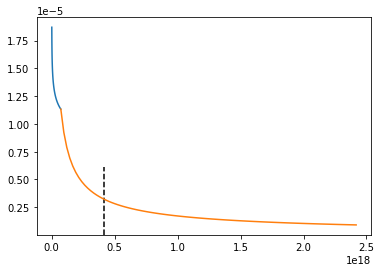

In [117]:
simulate_spectrum(10)

In [118]:
print(AsymmetricUncertainty(5,0.5,0.3) >  AsymmetricUncertainty(4,0.8,0.5))
print(AsymmetricUncertainty(5,0.5,0.3) >> AsymmetricUncertainty(4,0.8,0.5))

True
False


GRB                                                   160525B
dt%                                                 0.0181562
nu_o                                              8.51453e+14
F_o                       3.7775359688719236e-05 (+0.0, -inf)
nu_x                                              4.18808e+17
F_x         8.657846147846911e-08 (+5.453259804576449e-06,...
B_ox           0.9806618785598187 (+10.278055115304777, -inf)
B_x                                       0.95 (+0.27, -0.29)
Jak_dark                                                False
vdH_dark                                                False
Name: 425, dtype: object

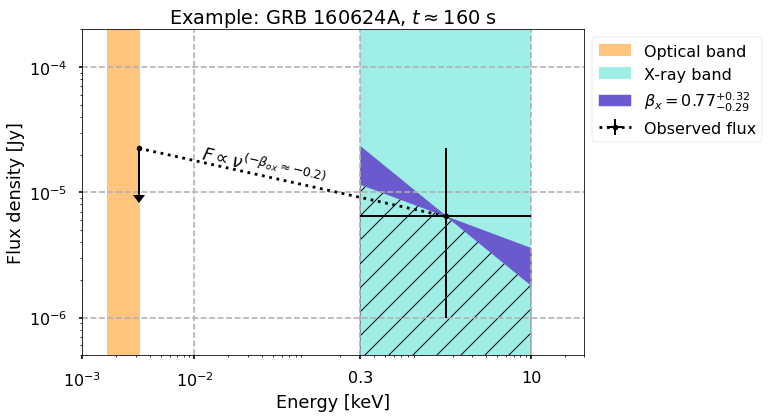

In [126]:
display(results.loc[425,])
E_range = np.logspace(np.log10(0.3),np.log10(10),100)

E_o = results.loc[421,"nu_o"]*6.62607015e-34/1.6021773E-16
E_x = results.loc[421,"nu_x"]*6.62607015e-34/1.6021773E-16
F_o = results.loc[421,"F_o"]
F_x = results.loc[421,"F_x"]
spectrum = E_range**-beta.value
scale = F_x.value/spectrum[len(spectrum)//2]
spectrum = scale * spectrum
spec1 = E_range**-beta.maximum
scale1 = F_x.value/spec1[len(spec1)//2]
spec1 = scale1 * spec1
spec2 = E_range**-beta.minimum
scale2 = F_x.value/spec2[len(spec2)//2]
spec2 = scale2 * spec2

plt.style.use("seaborn-poster")
fig,ax = plt.subplots(figsize=(9,6),facecolor="none")

plt.fill_between([0.003262755,0.0016531293],[1,1],alpha=0.5,fc="darkorange",label="Optical band")
plt.fill_between([0.3,10],[1,1],alpha=0.5,fc="turquoise",label="X-ray band")
plt.errorbar([E_o,E_x],[F_o.value,F_x.value],xerr=[(0,E_x-0.3),(0,10-E_x)],
             yerr=[(0.000013,F_x.value-1e-6),(0,F_o.value-F_x.value)],
             uplims=[1,0],capsize=0,elinewidth=2,marker=".",linestyle=":",color="k",label="Observed flux")
plt.fill_between(E_range,spectrum,fc="none",ec="k",hatch="/")
plt.fill_between(E_range,spec1,spec2,color="slateblue",label=r"$\beta_x=0.77_{-0.29}^{+0.32}$")
plt.text(1.1e-2,1.1e-5,r"$F\propto\nu^{(-\beta_{ox}\approx\mathrm{-0.2})}$",size=18,rotation=-13)

plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.grid(linestyle="--")
plt.xlim(1e-3,30)
plt.ylim(5e-7,2e-4)
plt.yscale("log")
plt.xscale("log")
plt.gca().set_xticks([0.001,0.01,0.3,10])
plt.gca().set_xticklabels(["$10^{-3}$","$10^{-2}$",0.3,10])
plt.title(r"Example: GRB 160624A, $t\approx160$ s")
plt.xlabel("Energy [keV]")
plt.ylabel("Flux density [Jy]")
fig.savefig("./Required Files/Generated Files (Python)/160624A.png",bbox_inches="tight",dpi=300)